In [1]:
import pandas as pd

# Load the 7 base files
races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
drivers = pd.read_csv("drivers.csv")
constructors = pd.read_csv("constructors.csv")
status = pd.read_csv("status.csv")
constructor_standings = pd.read_csv("constructor_standings.csv")
driver_standings = pd.read_csv("driver_standings.csv")

In [2]:
# Merge races and results
df = results.merge(races[['raceId', 'year', 'round']], on='raceId', how='left')

# Merge with drivers and constructors
df = df.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId', how='left')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left', suffixes=('', '_constructor'))

# Merge with status to track DNFs
df = df.merge(status, on='statusId', how='left')


In [3]:
# Sort before applying cumulative calculations
df.sort_values(['driverId', 'year', 'round'], inplace=True)

# Cumulative points and wins (up to the current race)
df['cumulative_points'] = df.groupby(['year', 'driverId'])['points'].cumsum() - df['points']
df['cumulative_wins'] = (
    df.groupby(['year', 'driverId'])['positionOrder']
    .transform(lambda x: (x == 1).cumsum()) - (df['positionOrder'] == 1).astype(int)
)

# Average finish (excluding current race)
df['average_finish'] = (
    df.groupby(['year', 'driverId'])['positionOrder']
    .transform(lambda x: x.shift().expanding().mean())
)

# DNF calculation
df['dnf'] = df['status'].apply(lambda x: 0 if x == 'Finished' else 1)
df['cumulative_dnf'] = df.groupby(['year', 'driverId'])['dnf'].cumsum() - df['dnf']


In [4]:
# Only keep last race for driver/constr standings prediction
final_race_rounds = df.groupby(['year'])['round'].transform('max')
df_final = df[df['round'] == final_race_rounds]


In [5]:
import numpy as np
# Convert all '\\N' strings to proper NaN
df.replace('\\N', np.nan, inplace=True)

# Convert all feature columns to numeric (in case any are still strings)
for col in ['cumulative_points', 'cumulative_wins', 'average_finish', 'cumulative_dnf', 'grid', 'laps', 'milliseconds']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any missing values in selected features
df = df.dropna(subset=[
    'cumulative_points', 'cumulative_wins', 'average_finish', 'cumulative_dnf',
    'grid', 'laps', 'milliseconds'
])

# Define X and y
features = ['cumulative_points', 'cumulative_wins', 'average_finish', 'cumulative_dnf',
            'grid', 'laps', 'milliseconds']
X = df[features]
y = df['positionOrder']  # or 'points' for regression

# Normalize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Define ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # For regression (predicting final standing or points)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


C:\Users\abhir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 25.9370 - mae: 3.7964 - val_loss: 8.6980 - val_mae: 2.2099
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1346 - mae: 2.1218 - val_loss: 7.6442 - val_mae: 2.0609
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8025 - mae: 2.0845 - val_loss: 7.2133 - val_mae: 1.9944
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0940 - mae: 1.9900 - val_loss: 6.9711 - val_mae: 1.9627
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7977 - mae: 1.9454 - val_loss: 6.7480 - val_mae: 1.9163
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7792 - mae: 1.9456 - val_loss: 6.9381 - val_mae: 1.9669
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5923 - mae: 1.8972 - val_loss: 6.5260 - val_mae: 1.9111
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5407 - mae: 1.9044 - val_loss: 6.4298 - val_mae: 1.8796
Epoch 9/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

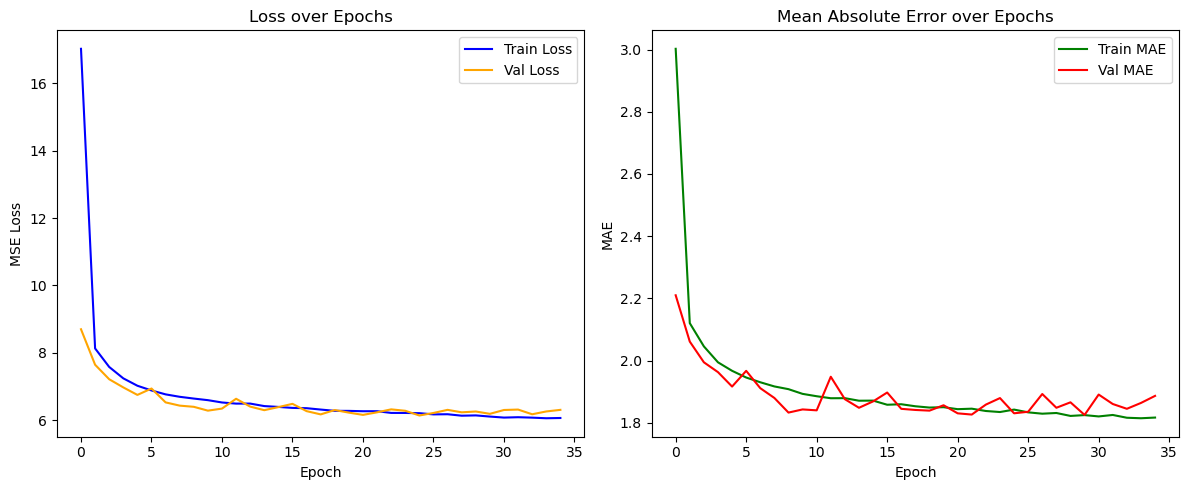

In [7]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Evaluate model on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Ensure y_test is a NumPy array
y_test_array = np.array(y_test)

# Display actual vs predicted
comparison_df = pd.DataFrame({
    'Actual': y_test_array.flatten(),
    'Predicted': y_pred.flatten()
})
print(comparison_df.head(10))

# Optional: Predicted & actual rank
comparison_df_sorted = comparison_df.copy()
comparison_df_sorted['Predicted_Rank'] = comparison_df_sorted['Predicted'].rank(ascending=False)
comparison_df_sorted['Actual_Rank'] = comparison_df_sorted['Actual'].rank(ascending=False)
comparison_df_sorted.sort_values(by='Predicted', ascending=False, inplace=True)

print("\nTop 10 Predicted Standings:")
print(comparison_df_sorted.head(10))



45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6353 - mae: 1.8845 

Test Loss (MSE): 6.3360
Test MAE: 1.8299
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
   Actual  Predicted
0       1   2.135988
1      14  14.016701
2       7   5.466534
3       2   4.078166
4       4   5.957006
5       6   6.314245
6       6   7.525746
7       1   5.453596
8       2   6.184785
9      14   8.399443

Top 10 Predicted Standings:
      Actual  Predicted  Predicted_Rank  Actual_Rank
1         14  14.016701             1.0         37.5
110       12  12.641143             2.0         92.0
686       18  12.539680             3.0          3.0
1226      16  12.320583             4.0         16.5
1322       8  12.152769             5.0        291.0
939       12  12.020327             6.0         92.0
14        11  11.997784             7.0        128.0
215        7  11.891243             8.0        377.0
579       14  11.847053             9.0         37.5
619       11  11.763073            10.0        128.0


R² Score: 0.5282
Mean Absolute Error: 1.8299
Mean Squared Error: 6.3360


<module 'matplotlib.pyplot' from 'C:\\Users\\abhir\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

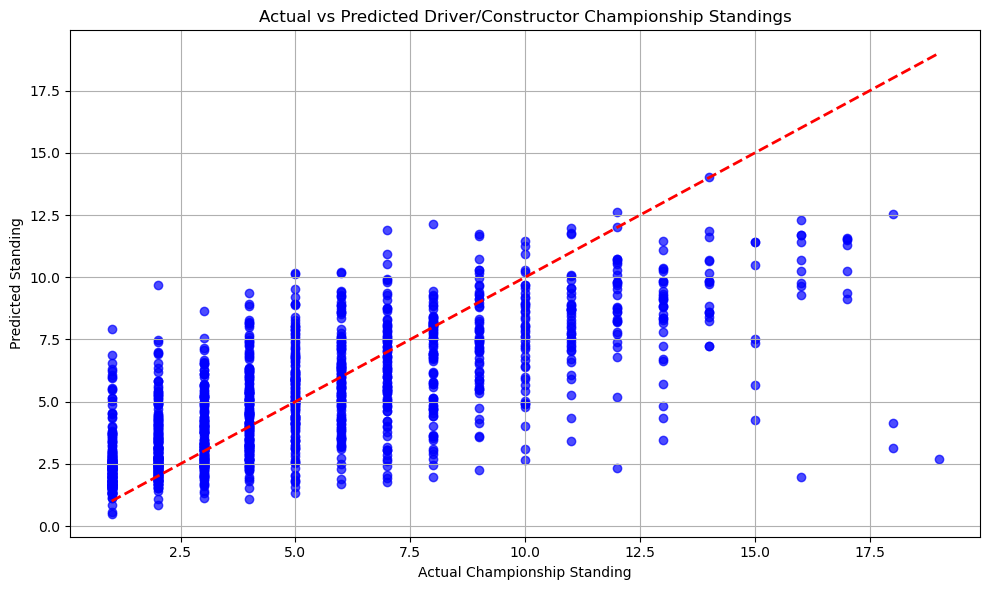

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Calculate evaluation metrics
r2 = r2_score(y_test_array, y_pred)
mae = mean_absolute_error(y_test_array, y_pred)
mse = mean_squared_error(y_test_array, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_array, y_pred, alpha=0.7, color='blue')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2)
plt.xlabel("Actual Championship Standing")
plt.ylabel("Predicted Standing")
plt.title("Actual vs Predicted Driver/Constructor Championship Standings")
plt.grid(True)
plt.tight_layout()
plt


In [10]:
# Sample input using correct column names from X
new_input = pd.DataFrame([{
    'cumulative_points': 325,
    'cumulative_wins': 7,
    'cumulative_dnf': 2,
    'grid': 1,
    'laps': 1230,
    'milliseconds': 5700000,
    'average_finish': 3.4,
}])


In [11]:
new_input = new_input[X.columns]  # Match order
new_input_scaled = scaler.transform(new_input)
pred = model.predict(new_input_scaled)

print(f"Predicted Standing: {pred[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Standing: 12.02


In [12]:
import joblib
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']